<br />

### Problem 9.2: Outliers in FRET binding curve, 20 pts

We often want to ascertain how tightly two proteins are bound by measuring their dissociation constant, $K_d$.  This is usually done by doing a titration experiment and then performing a regression.  For example, imagine two proteins, a and b may bind to each other in the reaction

\begin{align}
\text{ab} \rightleftharpoons \text{a} + \text{b}
\end{align}

with dissociation constant $K_d$.  At equilibrium

\begin{align}
K_d = \frac{c_a\,c_b}{c_{ab}},
\end{align}

were $c_i$ is the concentration of species $i$.  If we add known amounts of a and b to a solution such that the total concentration of a is $c_a^0$ and the total concentration of b is $c_b^0$, we can compute the equilibrium concentrations of all species.  Specifically, in addition to the equation above, we have conservation of mass equations,

\begin{align}
c_a^0 &= c_a + c_{ab}\\[1em]
c_b^0 &= c_b + c_{ab},
\end{align}

fully specifying the problem.  We can solve the three equations for $c_{ab}$ in terms of the known quantities $c_a^0$ and $c_b^0$, along with the parameter we are trying to measure, $K_d$.  We get

\begin{align}
c_{ab} = \frac{2c_a^0\,c_b^0}{K_d+c_a^0+c_b^0 + \sqrt{\left(K_d+c_a^0+c_b^0\right)^2 - 4c_a^0\,c_b^0}}.
\end{align}

The technique, then, is to hold $c_a^0$ fixed in the experiment and measure $c_{ab}$ for various $c_b^0$. We can then perform a regression to get $K_d$.

In order to do this, though, we need some readout of $c_{ab}$. For this problem, we will use FRET (fluorescence resonance energy transfer) to monitor how much of a is bound to b.  Specifically, we consider a to have a fluorophore and b to be its receptor.  When the two are unbound, we get a fluorescence signal per molecule of $f_0$.  When they are bound, the receptor absorbs the light coming out of the fluorophore, so we get less fluorescence per molecule, which we will call $f_q$ (for "quenched").  Let $f$ be the total per-fluorophore fluorescence signal.  Then, the measured fluorescence signal, $F$, is

\begin{align}
F = c_a^0\,V f = \left(c_a \,f_0 + c_{ab}\, f_q\right)V,
\end{align}

where $V$ is the reaction volume. We can absorb $V$ into the other parameters such that $\hat{f}_0 = f_0 V$ and $\hat{f}_q = f_q V$, giving

\begin{align}
F = \hat{f}_0(c_a^0 - c_{ab}) + \hat{f}_q\, c_{ab}
= \hat{f}_0\,c_a^0 - \frac{2(\hat{f}_0 - \hat{f}_q)c_a^0\,c_b^0}{K_d+c_a^0+c_b^0 + \sqrt{\left(K_d+c_a^0+c_b^0\right)^2 - 4c_a^0\,c_b^0}}.
\end{align}

Compute parameter estimates for $K_d$ with and without an outlier detection scheme for [this data set](../data/fret_binding_curve.csv). How do the results differ depending on whether or not you were trying to detect outliers?

*Note*: These are real data, but they are from an unpublished experiment here on campus. I therefore have not exposed the identities of the proteins a and b.

In [1]:
import glob
import os
import sys

import numpy as np
import pandas as pd
import scipy.signal

# Import Altair for high level plotting
import altair as alt
import altair_catplot as altcat

# Pevent bulky altair plots
alt.data_transformers.enable('json')

import bebi103
import bokeh
from bokeh.palettes import all_palettes
import itertools
from bokeh.models import Legend, LegendItem
bokeh.io.output_notebook()

Loading BokehJS ...

In [2]:
df = pd.read_csv("../data/fret_binding_curve.csv", comment = '#')
df

,buffer,fluorescence,a conc (nM),b conc (nM)
0,1256.5751,258316.2818,50.0,1500.000000
1,1256.5751,267722.6277,50.0,750.000000
2,1256.5751,267431.6620,50.0,375.000000
3,1256.5751,284596.2914,50.0,187.500000
4,1256.5751,254903.3958,50.0,93.750000
5,1256.5751,333810.6371,50.0,46.875000
6,1256.5751,370821.7778,50.0,23.437500
7,1256.5751,408856.1424,50.0,11.718750
8,1256.5751,431000.0000,50.0,5.859375
9,1256.5751,437000.0000,50.0,0.000000


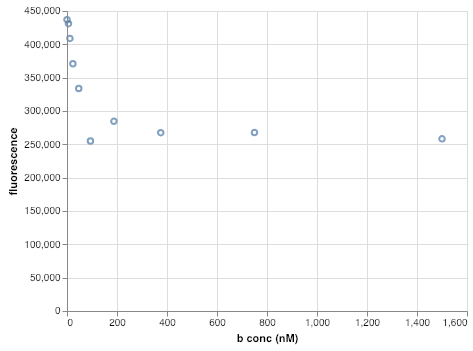

In [3]:
alt.Chart(df).mark_point().encode(
    x = alt.X("b conc (nM)"),
    y = alt.Y("fluorescence"))

LOL I wonder if there are any outliers

Given our known quantities and our goal, the relevant equation is:
\begin{align}
F
= \hat{f}_0\,c_a^0 - \frac{2(\hat{f}_0 - \hat{f}_q)c_a^0\,c_b^0}{K_d+c_a^0+c_b^0 + \sqrt{\left(K_d+c_a^0+c_b^0\right)^2 - 4c_a^0\,c_b^0}}.
\end{align}

The concentration of a is a set quantity in this experiment and that of b is our independent variabl, so we need parameter estimates of $K_d$, $\hat{f}_0$, and $\hat{f}_q$. Additionally we want to include a Gaussian error term $\sigma$ to reflect errors in measurement. Our priors are as follows:

$$\text{fl} = \text{Norm}(F(c_a^0), \sigma).$$ 

In [4]:
data = dict(N=len(df),
           cb=df['b conc (nM)'].values.astype(float))

$K_d = e^{\Delta g/RT}$

$\Delta G/RT$ ~ Norm(0, 1) 

$\hat{f}_0$ ~ Norm(10000, 1000) Flourescence is an ununited relative value, but in this experiment it appears to be between 100000 and 500000. Since $F= \hat{f}_0\,c_a^0$, we expect the highest fluorescence value to be $50*\hat{f}_0$ so we will choose a distribution with a wide variation at the top of this scale

$\hat{f}_q$ ~ Norm(5000, 500) We expect quenched molecules to have a much smaller fluorescence than the unquenched molecules, so we will choose a distribution half that of $\hat{f}_0$

$\sigma$ ~ Half-Norm(0, 5000): 

Additionally, we know that 
$c_a^0$ = 50 nM

In [25]:
sm = bebi103.stan.StanModel(file='./9.2_prior.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7741719f560e74870eb104cdeabe6fea NOW.
/Users/jaredlivingston/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/w3/tn6brvj12bx95d_v766ht54h0000gn/T/tmp9mvulp1e/stanfit4anon_model_7741719f560e74870eb104cdeabe6fea_1335952422517167317.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [26]:
samples = sm.sampling(data=data, algorithm="Fixed_param",
                          warmup=0,
                          chains=1,
                          iter=1000)

In [27]:
df_gen = bebi103.stan.to_dataframe(samples, diagnostics=False)

In [28]:
cols = ["fl[1]", "fl[2]", "fl[3]", "fl[4]", "fl[5]",
        "fl[6]", "fl[7]", "fl[8]", "fl[9]", "fl[10]"]

In [29]:
df_gen_fl = df_gen[cols]
df_gen_fl = df_gen_fl.stack(level=0)
df_gen_fl = df_gen_fl.reset_index()
df_gen_fl = df_gen_fl.sort_index(level=1)


# Renaming the columns with useful names
df_gen_fl = df_gen_fl.rename(columns={'level_0': 'model', 
                                  'level_1': 'cb',
                                  0:'fluorescence signal'})

# Renaming the conditions with more descriptive names
for i in range(len(cols)):
    df_gen_fl = df_gen_fl.replace({cols[i]:data['cb'][i]})
    



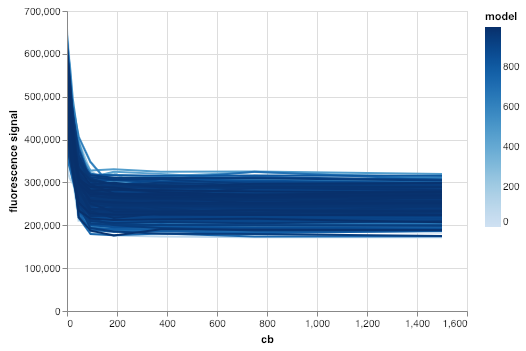

In [30]:
alt.Chart(df_gen_fl).mark_line().encode(
    x = alt.X('cb'),
    y = alt.Y('fluorescence signal'),
    color = alt.Color('model')).interactive()
    

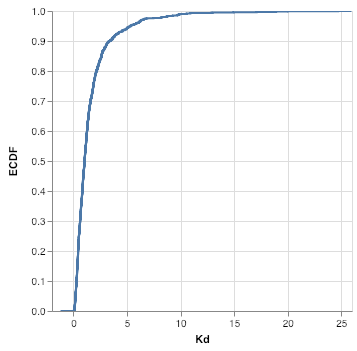

In [31]:
make_ecdf(df_gen, "Kd:Q")

In [37]:
sm2 = bebi103.stan.StanModel(file='./9.2_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8e3821f656f5fd4cbe39c94ebf8038e4 NOW.
/Users/jaredlivingston/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/w3/tn6brvj12bx95d_v766ht54h0000gn/T/tmpe1k5izea/stanfit4anon_model_8e3821f656f5fd4cbe39c94ebf8038e4_5092771696481932302.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [38]:
data = dict(N=len(df),
           cb=df['b conc (nM)'].values.astype(float),
           fl=df['fluorescence'].values.astype(float))

In [39]:
samples2 = sm2.sampling(data=data, 
                       control=dict(adapt_delta = .9999999,
                                    max_treedepth = 12),
                       warmup=2000, 
                       iter=3000, 
                       thin=5)
bebi103.stan.check_all_diagnostics(samples2)

n_eff / iter looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0.0 of 800 (0.0%) iterations ended with a divergence.
0 of 800 (0.0%) iterations saturated the maximum tree depth of 12.
E-BFMI indicated no pathological behavior.


0

In [40]:
df2 = bebi103.stan.to_dataframe(samples2, diagnostics=False, inc_warmup=False)

In [41]:
df2.tail()

,chain,chain_idx,warmup,Delta_G,f0,fq,sigma_g,Kd,F[1],F[2],...,fl_ppc[2],fl_ppc[3],fl_ppc[4],fl_ppc[5],fl_ppc[6],fl_ppc[7],fl_ppc[8],fl_ppc[9],fl_ppc[10],lp__
795,4,196,0,-0.029832,8872.292367,4913.485353,14106.373132,0.970608,252179.316827,258270.410328,...,283935.147433,278200.577121,291046.977111,327304.713971,347981.563793,366653.526129,423807.558209,426088.158666,439723.560026,-101.283338
796,4,197,0,1.010776,8933.482204,4711.146569,17232.900027,2.747732,242729.086709,249429.596067,...,267840.644642,273404.083555,278189.056102,318521.738477,338800.210484,392040.972309,397618.164821,437825.132572,445381.833433,-102.141955
797,4,198,0,0.173874,9025.392090,4568.006457,15031.394756,1.189905,235755.100870,242639.964829,...,254712.373110,254093.213953,298290.734402,318857.340570,340904.355175,412658.519504,406816.479428,413951.616144,454426.303950,-101.956610
798,4,199,0,1.616439,8705.101290,4504.474285,16003.456811,5.035127,232657.052468,239582.220688,...,231520.745185,262332.637661,279634.324678,303175.379226,355525.251544,355244.109282,409745.994326,424046.476893,414163.058075,-103.709396
799,4,200,0,1.140377,8841.502906,4739.968697,15298.669273,3.127949,244013.507213,250564.523482,...,258325.591988,254006.738431,268972.793698,325425.951997,332356.012597,395954.071394,400847.080420,395314.213583,438266.278064,-101.492354


In [42]:
parameters = (['Kd', 'f0', 'fq','sigma_g'] 
            + ['lp__'])
def plot_parallel_coordinate(samples, parameters):
    samples_dataframe = bebi103.stan.to_dataframe(samples)
    # Which parametets to use in parallel coordinate plot
    pars = (parameters)

    # Transformations to get them all on the same scale
    transformation = (  [lambda x: x / 10, None, None] 
                      + [lambda x: x / 10]*(len(pars)-4)
                      + [lambda x: x / np.abs(x).max()])

    bokeh.io.show(bebi103.viz.parcoord_plot(samples,
                                            pars=pars,
                                            transformation=transformation,
                                            xtick_label_orientation='vertical'))
    
plot_parallel_coordinate(samples2, parameters)

In [43]:
bokeh.io.show(bebi103.viz.corner(samples2,
                                        pars=['Kd', 'f0', 'fq','sigma_g']))

In [44]:
p = bebi103.viz.predictive_ecdf(samples2,
                                name='fl_ppc', 
                                data=df["fluorescence"],
                                x=np.linspace(200000, 500000),
                                percentiles=[99, 80, 60, 40])
p.plot_width=800

bokeh.io.show(p)

In [45]:
# First let's make a helper plotting function
def make_ecdf(dataframe, data):
    c = altcat.catplot(data=dataframe,
               mark='line',
               encoding=dict(x=alt.X(data,
                                     scale=alt.Scale(
                                           clamp=True))),
               transform='ecdf'
              ).properties(height=300,
                           width=300).interactive()
    return c

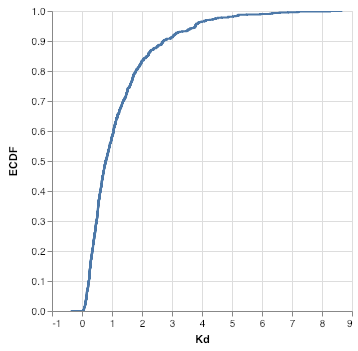

In [46]:
make_ecdf(df2, "Kd:Q")

In [47]:
Kd = df2["Kd"].mean() 
Kd

1.2048911731208027

In [48]:
sm3 = bebi103.stan.StanModel(file='./9.2_student_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7e8756ef66ac6c04ed01226f99154ca7 NOW.
/Users/jaredlivingston/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/w3/tn6brvj12bx95d_v766ht54h0000gn/T/tmpfq2c_tv6/stanfit4anon_model_7e8756ef66ac6c04ed01226f99154ca7_3394866351216609815.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [49]:
samples3 = sm3.sampling(data=data, 
                       control=dict(adapt_delta = .9999999,
                                    max_treedepth = 12),
                       warmup=2000, 
                       iter=3000, 
                       thin=5)
bebi103.stan.check_all_diagnostics(samples3)

/Users/jaredlivingston/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


n_eff / iter looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0.0 of 800 (0.0%) iterations ended with a divergence.
0 of 800 (0.0%) iterations saturated the maximum tree depth of 12.
E-BFMI indicated no pathological behavior.


0

In [50]:
df3 = bebi103.stan.to_dataframe(samples3, diagnostics=False, inc_warmup=False)

In [51]:
df3.tail()

,chain,chain_idx,warmup,Delta_G,f0,fq,sigma,nu,Kd,F[1],...,fl_ppc[2],fl_ppc[3],fl_ppc[4],fl_ppc[5],fl_ppc[6],fl_ppc[7],fl_ppc[8],fl_ppc[9],fl_ppc[10],lp__
795,4,196,0,-0.119362,8763.267813,4935.056250,6582.784236,1.471619,0.887487,253033.347586,...,255744.975670,264231.629004,287527.807887,312889.279233,339989.574691,373781.787076,402509.276832,411439.111293,444418.276018,-97.704054
796,4,197,0,-2.195124,8766.846353,4719.566537,5419.430161,1.141038,0.111345,242520.264447,...,246764.947438,260421.574207,273012.005642,302635.488043,337957.267550,370087.302008,399808.592099,414126.350424,445409.675320,-104.764338
797,4,198,0,0.887636,8712.841077,4864.218046,11291.784933,1.605009,2.429379,249709.778134,...,243072.705249,249724.302206,281852.208013,294095.262938,296311.188261,371852.887476,387133.377960,302688.127160,425969.153627,-100.147752
798,4,199,0,-1.235503,8888.492709,5001.458217,6695.842447,2.467365,0.290688,256377.587822,...,261475.270042,275014.782896,295634.740786,321349.327160,354406.070950,359048.893491,411310.612238,424904.986805,436032.307264,-98.322550
799,4,200,0,0.234948,8838.036887,4729.174545,10884.319156,8.417342,1.264843,243248.031632,...,266693.778918,267531.262270,264620.060006,336625.529488,375817.169032,402933.236521,406052.816519,428764.724503,442507.384305,-99.012018


In [52]:
parameters = (['Kd', 'f0', 'fq','sigma','nu'] 
            + ['lp__'])
def plot_parallel_coordinate(samples, parameters):
    samples_dataframe = bebi103.stan.to_dataframe(samples)
    # Which parametets to use in parallel coordinate plot
    pars = (parameters)

    # Transformations to get them all on the same scale
    transformation = (  [lambda x: x / 10, None, None] 
                      + [lambda x: x / 10]*(len(pars)-4)
                      + [lambda x: x / np.abs(x).max()])

    bokeh.io.show(bebi103.viz.parcoord_plot(samples,
                                            pars=pars,
                                            transformation=transformation,
                                            xtick_label_orientation='vertical'))
    
plot_parallel_coordinate(samples3, parameters)

In [53]:
bokeh.io.show(bebi103.viz.corner(samples3,
                                        pars=['Kd', 'f0', 'fq','sigma', 'nu']))

In [54]:
p = bebi103.viz.predictive_ecdf(samples3,
                                name='fl_ppc', 
                                data=df["fluorescence"],
                                x=np.linspace(200000, 500000),
                                percentiles=[99, 80, 60, 40])
p.plot_width=800

bokeh.io.show(p)

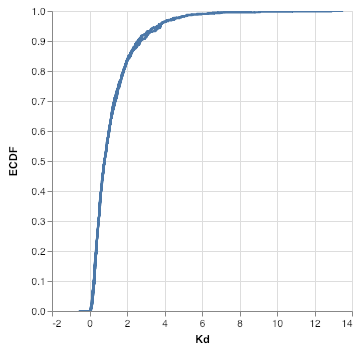

In [55]:
make_ecdf(df3, "Kd:Q") + make_ecdf(df2, "Kd:Q")

In [56]:
Kd = df3["Kd"].mean() 
Kd

1.2075477463350808

In [57]:
sm4 = bebi103.stan.StanModel(file='./9.2_good_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_912b898c62da7ea81dd1df61f2232a09 NOW.
/Users/jaredlivingston/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/w3/tn6brvj12bx95d_v766ht54h0000gn/T/tmp9gvspmrz/stanfit4anon_model_912b898c62da7ea81dd1df61f2232a09_7106298406606636211.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [58]:
samples4 = sm4.sampling(data=data, 
                       control=dict(adapt_delta = .9999999,
                                    max_treedepth = 12),
                       warmup=2000, 
                       iter=3000, 
                       thin=5)
bebi103.stan.check_all_diagnostics(samples4)

n_eff / iter looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0.0 of 800 (0.0%) iterations ended with a divergence.
0 of 800 (0.0%) iterations saturated the maximum tree depth of 12.
E-BFMI indicated no pathological behavior.


0

In [59]:
df4 = bebi103.stan.to_dataframe(samples4, diagnostics=False, inc_warmup=False)

In [60]:
df4.tail()

,chain,chain_idx,warmup,Delta_G,f0,fq,sigma[1],sigma[2],w[1],w[2],...,fl_ppc[2],fl_ppc[3],fl_ppc[4],fl_ppc[5],fl_ppc[6],fl_ppc[7],fl_ppc[8],fl_ppc[9],fl_ppc[10],lp__
795,4,196,0,-0.695069,8906.863867,4972.669111,5602.821575,16491.295256,0.311486,0.864522,...,273743.706073,275351.037795,292087.880915,330348.104289,326267.873946,389791.992570,437334.991599,428183.558906,454057.174248,-124.577224
796,4,197,0,-0.969749,8798.895264,4752.607181,8800.715676,16139.457832,0.399560,0.383398,...,247922.178570,256379.468650,249878.738706,314696.853766,353006.626281,357959.430101,419934.177328,433863.277071,455602.242580,-121.404108
797,4,198,0,-2.188846,8764.613305,4826.741563,5211.728499,15824.900271,0.867056,0.180731,...,260733.424765,256998.806790,302771.752811,293623.045810,334618.265817,385623.491890,419216.245676,418614.055582,454104.779124,-131.374720
798,4,199,0,0.441828,9004.475615,4759.700746,6490.188701,18985.596077,0.256077,0.171537,...,231344.612388,278633.464792,263076.180227,314580.598014,345701.240667,377717.118061,408925.243914,454349.472906,447476.440431,-123.480034
799,4,200,0,1.213596,8417.967074,4983.394887,8853.483284,20179.976413,0.127905,0.878655,...,262945.137995,270096.139109,292314.934767,282073.392509,346929.730785,368217.766210,405527.427852,412975.816752,434174.857534,-130.858985


In [61]:
parameters = (['Kd', 'f0', 'fq','sigma[1]','sigma[2]'] 
            + ['lp__'])
    
plot_parallel_coordinate(samples4, parameters)

In [62]:
bokeh.io.show(bebi103.viz.corner(samples4,
                                        pars=['Kd', 'f0', 'fq','sigma[1]','sigma[2]']))

In [63]:
p = bebi103.viz.predictive_ecdf(samples4,
                                name='fl_ppc', 
                                data=df["fluorescence"],
                                x=np.linspace(200000, 500000),
                                percentiles=[99, 80, 60, 40])
p.plot_width=800

bokeh.io.show(p)

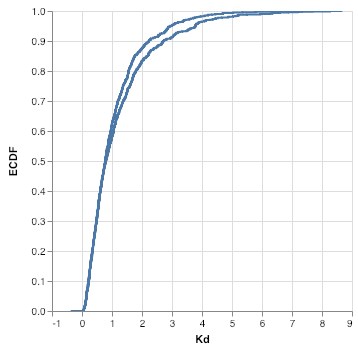

In [64]:
make_ecdf(df4, "Kd:Q") + make_ecdf(df2, "Kd:Q")

In [65]:
Kd = df4["Kd"].mean() 
Kd

1.051044086014163

In [66]:
df_res = pd.DataFrame(columns=['method', 'hbd_low', 'median', 'hbd_high'])

In [67]:
kd_samples = samples2.extract('Kd')['Kd']
df_res = df_res.append(pd.DataFrame({'method': ['mcmc'],
                                     'hbd_low': [bebi103.stan.hpd(kd_samples, mass_frac=0.95)[0]],
                                     'median': [np.median(kd_samples)],
                                     'hbd_high': [bebi103.stan.hpd(kd_samples, mass_frac=0.95)[1]]}),
                      ignore_index=True)
    
kd_samples = samples3.extract('Kd')['Kd']
df_res = df_res.append(pd.DataFrame({'method': ['student_t'],
                                     'hbd_low': [bebi103.stan.hpd(kd_samples, mass_frac=0.95)[0]],
                                     'median': [np.median(kd_samples)],
                                     'hbd_high': [bebi103.stan.hpd(kd_samples, mass_frac=0.95)[1]]}),
                      ignore_index=True)
    
kd_samples = samples4.extract('Kd')['Kd']
df_res = df_res.append(pd.DataFrame({'method': ['good_bad'],
                                     'hbd_low': [bebi103.stan.hpd(kd_samples, mass_frac=0.95)[0]],
                                     'median': [np.median(kd_samples)],
                                     'hbd_high': [bebi103.stan.hpd(kd_samples, mass_frac=0.95)[1]]}),
                      ignore_index=True)


    
# Take a look
df_res

,method,hbd_low,median,hbd_high
0,mcmc,0.050209,0.790625,3.784168
1,student_t,0.079122,0.804994,3.688051
2,good_bad,0.049489,0.776333,2.948627
